In [129]:
import rasterio
import rasterio.plot
from rasterio.crs import CRS
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

# example


In [130]:
x = np.linspace(-4.0, 4.0, 240)
y = np.linspace(-3.0, 3.0, 180)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-2 * np.log(2) * ((X + 1) ** 2 + (Y) ** 2) / 1**2)
Z2 = np.exp(-2 * np.log(2) * ((X - 1) ** 2 + (Y) ** 2) / 1**2)

Z = (90 * Z2 + 5 * Z1) / (Z2 + Z1)
Zn = [Z1, Z2]
Z = np.sum([a*b for a,b in zip(Zn, [5, 90])], axis=0) / np.sum(Zn, axis=0)

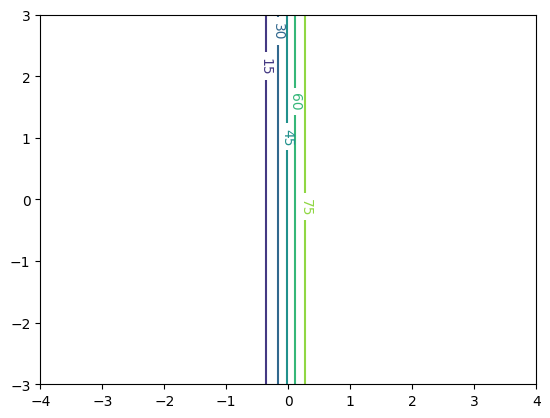

In [131]:
p = plt.contour(X, Y, Z)
plt.clabel(p, inline=1, fontsize=10)
plt.show()

In [132]:
# from rasterio.transform import Affine

# res = (x[-1] - x[0]) / 240.0
# transform = Affine.translation(x[0] - res / 2, y[0] - res / 2) * Affine.scale(res, res)
# transform

dkm


In [133]:
with rasterio.open(
    "new.tif",
    "w",
    driver="GTiff",
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
) as dst:
    dst.write(Z, 1)

/home/till/projects/map/env/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


/home/till/projects/map/env/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


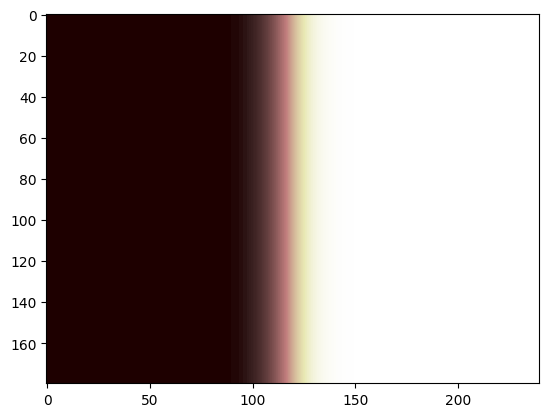

In [134]:
src = rasterio.open("new.tif")
plt.imshow(src.read(1), cmap='pink')
plt.show()

# real


In [135]:
points = gpd.read_file('../waiting_time_per_point.csv')
points.wait = points.wait.astype(float)
points.lat = points.lat.astype(float)
points.lon = points.lon.astype(float)
points = points[points['wait'] <= 100]

points.geometry = gpd.points_from_xy(points.lon, points.lat)
points.crs = CRS.from_epsg(4326)
points = points.to_crs(epsg=3857)

In [136]:
germany = [5.0, 48.0, 15.0, 55.0]
europe = [-12.0, 35.0, 45.0, 71.0]
world = [-180.0, -90.0, 180.0, 90.0]
map = germany

from shapely.geometry import Polygon

polygon = Polygon([(5.0, 48.0), (5.0, 55.0), (15.0, 55.0), (15.0, 48.0), (5.0, 48.0)])
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])  
polygon = polygon.to_crs(epsg=3857)

In [137]:
xx, yy = polygon.geometry[0].exterior.coords.xy

# Note above return values are of type `array.array` 
xx = xx.tolist()
yy = yy.tolist()


In [138]:
points = points[points.geometry.within(polygon.geometry[0])]

In [139]:
points.geometry.y

6977     6.107535e+06
6985     6.109461e+06
6987     6.109892e+06
6988     6.109915e+06
6993     6.110101e+06
             ...     
13386    7.345679e+06
13390    7.347399e+06
13394    7.348244e+06
13400    7.349279e+06
13411    7.352203e+06
Length: 2564, dtype: float64

In [140]:
import numpy as np

def makeGaussian(fwhm, x0, y0):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    return np.exp(-4*np.log(2) * ((X-x0)**2 + (Y-y0)**2) / fwhm**2)

DENSITY = 10
x_density = int(map[2] - map[0]) * DENSITY
y_density = int(map[3] - map[1]) * DENSITY
x = np.linspace(xx[0], xx[2], x_density)
y = np.linspace(yy[0],yy[2], y_density)
X, Y = np.meshgrid(x, y)

# TODO fwhm to stdv
RADIUS_M = 100000

def get_dist(lat, lon):
    return makeGaussian(RADIUS_M, lon, lat)


Zn = [
    get_dist(lat, lon)
    for lat, lon in zip(points.geometry.y, points.geometry.x)
]
Z = np.sum([a*b for a,b in zip(Zn, points.wait)], axis=0) / np.sum(Zn, axis=0)

In [141]:
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint as GCP


# https://gis.stackexchange.com/questions/425903/getting-rasterio-transform-affine-from-lat-and-long-array

ul = (xx[1], yy[1])  # in lon, lat / x, y order
ll = (xx[0], yy[0])
ur = (xx[2], yy[2])
lr = (xx[3], yy[3])
cols, rows = x_density, y_density

gcps = [
    GCP(0, 0, *ul),
    GCP(0, cols, *ur),
    GCP(rows, 0, *ll),
    GCP(rows, cols, *lr)
]

transform = from_gcps(gcps)

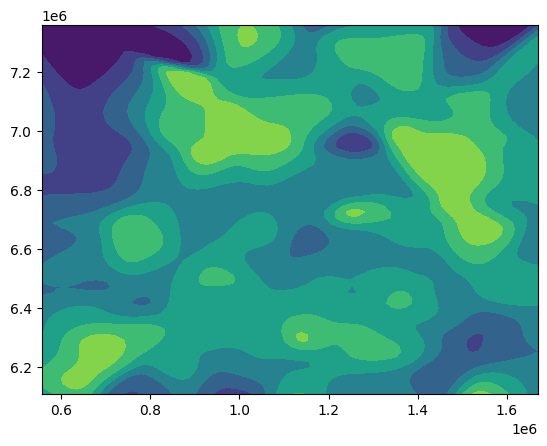

In [145]:
p = plt.contourf(X, Y, Z)
#plt.clabel(p, inline=1, fontsize=10)
plt.show()

In [146]:
with rasterio.open(
    "map.tif",
    "w",
    driver="GTiff",
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    crs=CRS.from_epsg(3857),
    transform=transform,
    dtype=Z.dtype,
) as dst:
    dst.write(Z, 1)

In [147]:
import matplotlib.colors as colors
from matplotlib import cm

cmap = colors.ListedColormap(['#008200', '#00c800','#00ff00', '#c8ff00', '#ffff00', '#ffc800', '#ff8200', '#ff0000', '#c80000', '#820000'])
boundaries = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

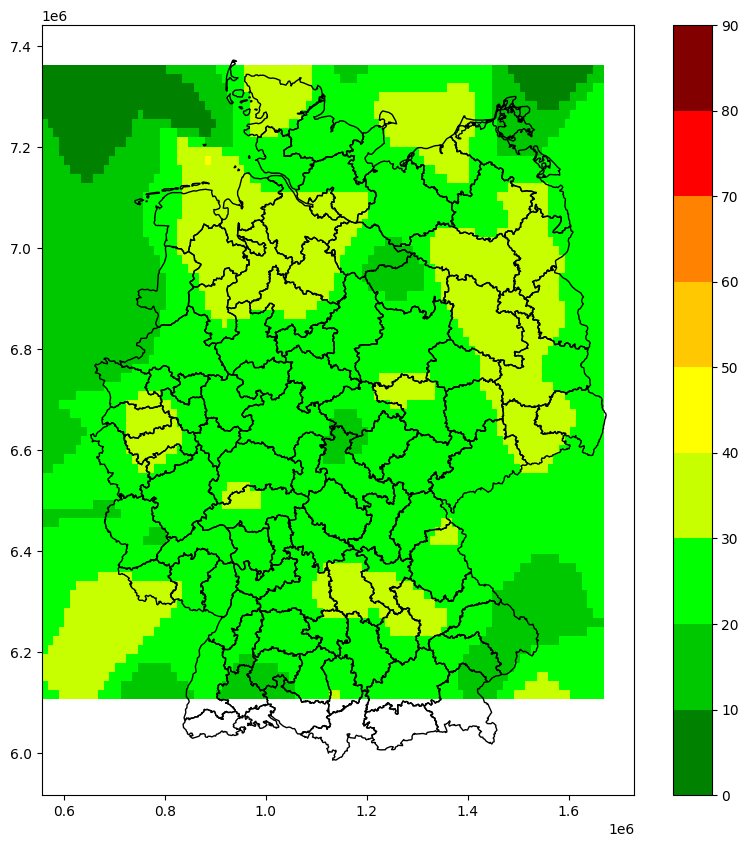

In [148]:
countries = gpd.read_file("german_shape/ROR5000.shp")
countries = countries.to_crs(epsg=3857)
raster = rasterio.open("map.tif")
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(raster, origin='lower', ax=ax, cmap=cmap, norm=norm)
countries.plot(ax=ax, facecolor='none', edgecolor='black')

fig.colorbar( cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)